# Example 2: Hyperparameters and Hyperparameter Tuning with the CIM 

This notebook serves as a continuation of example 1, with a focus on observing specific CIM hyperparameters and their impact on the internal dynamics of our simulator. We also discuss hyperparameter tuning with Bayesian optimization Hyperband, which creates a search space across a subset of hyperparameters and tunes these particular hyperparameters to find lower minimum energies.

## Loading J matrix and hyperparameters

In [12]:
# loading imports
import sys
from pathlib import Path
sys.path.append(str(Path.cwd()) + "\\..\\") # append repo folder to list of search directories 

from cim_optimizer.solve_Ising import *
from cim_optimizer.CIM_helper import brute_force, load_adjMatrix_from_rudy

%matplotlib inline

In [16]:
instance_path_str_MAXCUT = str(Path.cwd()) + "\\..\\instances\\MC_Instances_NPZ\\"

# 20 spin MAXCUT problem
N = 20
mc_id = 1 # select first example of 20 spin MAXCUT problem
J = - np.load(instance_path_str_MAXCUT + f"MC50_N={N}_{mc_id}.npz") # load J matrix for 50% density MAX-CUT problem

# obtain ground state energy 
loaded_energies = np.load(instance_path_str_MAXCUT + f"MC50_N={N}_ground_energies.npz")
ground_state_energy = (loaded_energies)[mc_id-1]

# CAC hyperparameters
p=-0.3 
alpha= 0.7 
beta=0.25 
gamma= 0.010
delta= 12 
mu=0.8 
rho=1.2 
tau=150

# additional trial information
num_trials = 1
time_span = 2500
nsub = 0.04

## Solving with the simulated coherent Ising machine

We now apply the CAC CIM model to our J matrix for a single trial with 2500 steps and preset hyperparameters. Note that all hyperparameters are configurable; the only required input is the J matrix. While the hyperparameters are intended for the MAX-CUT N=100 problem, it is still fairly similar and thus yields better results.

In [4]:
test_with_hyperparameters = Ising(J).solve(num_runs = num_trials, num_timesteps_per_run = time_span, target_energy = ground_state_energy, return_spin_trajectories_all_runs=True,
                      cac_time_step=nsub, cac_r=p, cac_alpha=alpha, cac_beta=beta, cac_gamma=gamma, cac_delta=delta,
                      cac_mu=mu,cac_rho=rho,cac_tau=tau)

1
No External Field Detected
Target Ising Energy: -29.0.
Best Ising Energy Found: -29.0.
Corresponding Spin Configuration: [-1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1.
  1. -1.].
Time Elapsed: 0.810516357421875.
Number of Runs Completed: 1.
Success Probability: 1.0.


In [5]:
test_without_hyperparameters = Ising(J).solve()

1
No External Field Detected
Target Ising Energy: -inf.
Best Ising Energy Found: -25.0.
Corresponding Spin Configuration: [-1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1. -1.  1.  1. -1.  1. -1.  1.
  1.  1.].
Time Elapsed: 0.4223160743713379.
Number of Runs Completed: 1.


The well-selected hyperparameters is capable of achieving the ground state energy while also maintaining much more complex dynamics (as seen from the plots below). While the particular selection can be done via grid search or any other hyperparameter selection method, we also provide a BOHB implementation of all three solvers that allows for tuning of particular model hyperparameters around some initially selected values (dependent on the solver).

In [18]:
from cim_optimizer.optimal_params import maxcut_100_params
test = Ising(J).solve(target_energy = ground_state_energy, return_spin_trajectories_all_runs=True, **maxcut_100_params())

No External Field Detected
Target Ising Energy: -29.0.
Best Ising Energy Found: -29.0.
Corresponding Spin Configuration: [-1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1.
  1. -1.].
Time Elapsed: 0.9942452907562256.
Number of Runs Completed: 1.
Success Probability: 1.0.


Alternatively, we can use the predefined hyperparameters stored in `optimal_params` to save time. This is particularly useful for problems that share similarities to MAX-CUT or SK, as those are well-studied problems with defined optimal hyperparameters.

## Internal dynamics of the CIM

Compared to example 1, the internal spin trajectories are much more complicated. This is due to a better selection of our hyperparameters, which allows for a more robust search for the minima. Note that the spin trajectory amplitudes flipping signs is indicative of working towards a new minima, allowing the CIM simulator to continue stepping towards the ground state energy instead of being stuck in the first local minima.

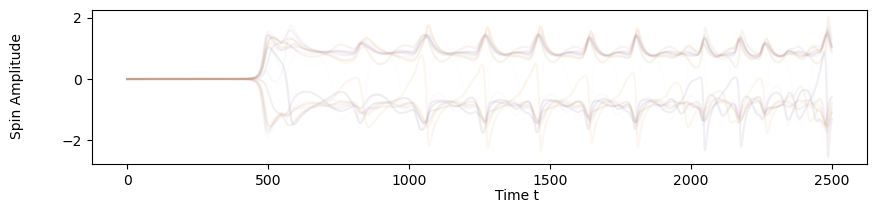

In [6]:
test_with_hyperparameters.result.plot_spin_trajectories() 

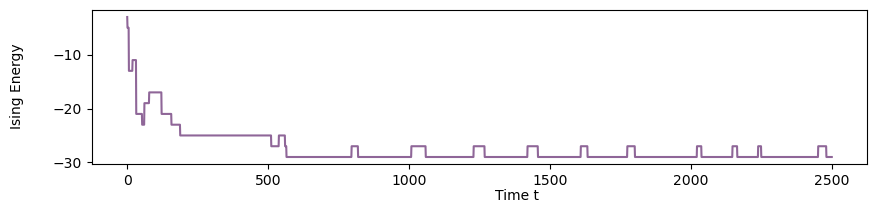

In [7]:
test_with_hyperparameters.result.plot_spin_trajectories(plot_type="energy")

## Bayesian Optimization Hyperband

We now pivot to a large MAX-CUT problem where the improvement via BOHB is noticeable. In particular, we look at a 500 spin problem where the ground state energy cannot be easily achieved.

In [8]:
# 500 spin MAX-CUT problem
N = 500
mc_id = 1
J = - np.load(instance_path_str_MAXCUT + f"MC50_N={N}_{mc_id}.npz")["arr_0"]

# obtain ground state energy
loaded_energies = np.load(instance_path_str_MAXCUT + f"MC50_N={N}_ground_energies.npz")
ground_state_energy = (loaded_energies)[mc_id-1]

# CAC hyperparameters
p= 0.9
alpha= 1.1
beta= 0.35 
gamma= 0.0005
delta= 15 
mu= 0.7
rho= 1 
tau= 200
noise = 0.00

# additional run information
num_trials = 1
time_span = 25000
nsub = 0.02

To save space, we add an additional parameter: suppress_statements. By setting this to True, we ignore print statements, but all outputs can still be accessed. For example, we plot the spin amplitude evolution of the CIM.

1
No External Field Detected
Minimum Energy Achieved: -4160.0


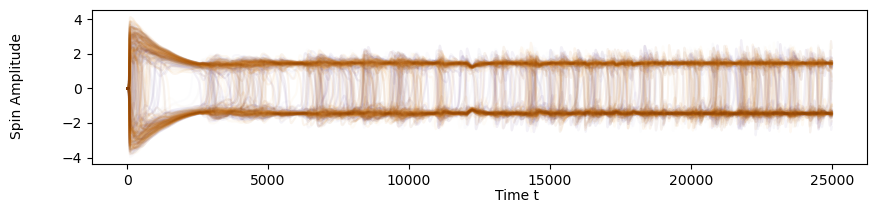

In [9]:
test_500_spin_problem = Ising(J).solve(num_runs = num_trials, num_timesteps_per_run = time_span, target_energy = ground_state_energy, return_spin_trajectories_all_runs=True,
                      cac_time_step=nsub, cac_r=p, cac_alpha=alpha, cac_beta=beta, cac_gamma=gamma, cac_delta=delta,
                      cac_mu=mu,cac_rho=rho,cac_tau=tau,suppress_statements=True)

test_500_spin_problem.result.plot_spin_trajectories(plot_type="spins")
print("Minimum Energy Achieved: {}".format(test_500_spin_problem.result.lowest_energy))

Note that the ground state energy of this problem cannot be computed by the CIM with the present hyperparameters. We now apply Bayesian Optimization Hyperband to tune particular hyperparameters to try and achieve a more optimal minimum energy.

In [10]:
test_500_spin_problem_tune = Ising(J).solve(num_runs = num_trials, num_timesteps_per_run = time_span, target_energy = ground_state_energy, return_spin_trajectories_all_runs=True,
                      cac_time_step=nsub, cac_r=p, cac_alpha=alpha, cac_beta=beta, cac_gamma=gamma, cac_delta=delta,
                      cac_mu=mu,cac_rho=rho,cac_tau=tau,suppress_statements=True,hyperparameters_autotune=True)

print("Minimum Energy Achieved: {}".format(test_500_spin_problem_tune.result.lowest_energy))

1
No External Field Detected
Tuned parameters: {'T_time': 25000, 'time_step': 0.02, 'gamma': 0.0005, 'delta': 15, 'mu': 0.7, 'tau': 200, 'noise': 0, 'H0': None, 'stop_when_solved': False, 'num_sol': 10, 'custom_fb_schedule': None, 'custom_pump_schedule': None, 'device': device(type='cpu'), 'batch_size': 1, 'cac_nonlinearity': <built-in method tanh of type object at 0x00007FF801F09520>, 'beta': 0.3068540564276434, 'r': 0.9809214529701906, 'alpha': 1.2981510721396512, 'rho': 0.8188871873523109}.
Minimum Energy Achieved: -4176.0


Although tuning is still not sufficient to reach the ground state energy, it is capable of improving upon the performance of the minimum ground state energy achieved. The tuned hyperparameters vary from model to model, but in the case of the CAC solver, these include cac_beta, cac_r, cac_alpha, and cac_rho.